# Section I: Import Libraries

This section imports all the necessary Python libraries and packages required for data handling, preprocessing, feature engineering, model building, and evaluation. These libraries include Pandas for data manipulation, NumPy for numerical operations, Scikit-learn for preprocessing and model evaluation, and TensorFlow/Keras for building the CNN model.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau



# Section II: Define Function to Calculate Slope

This section defines the cal_slope function, which calculates the slope of a linear regression line for a series of values. This slope represents the trend of the data over a rolling window and will be used as a feature in the predictive model.

In [2]:
def cal_slope(values):
    x = np.arange(len(values))
    y = values
    if len(np.unique(y)) == 1:  
        return 0
    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y)
    slope = model.coef_[0]
    return slope



# Section III: Data Loading and Feature Engineering

In this section, data from multiple CSV files is loaded and processed. The data is filtered to include only valid entries, resampled to a uniform time interval, and various features are engineered from the raw data. These features include the original SpO2 values, the computed slope (trend), statistical features such as mean and standard deviation, and a rolling average

In [3]:
# Directory containing all the  patient CSV files
dir = '/Users/adityaiyer/Downloads/Zoll data 2/spo2_data'


X_list = []
y_list = []


#Process the  CSV files
for filename in os.listdir(dir):
    if filename.endswith(".csv"):
        file_path = os.path.join(dir, filename)
        
        
        df = pd.read_csv(file_path)
        
       
        df['datetime'] = pd.to_datetime(df['datetime'])
        
       
        df_valid = df[df['Spo2_data_status'] == 'valid']
        
       
        df_valid.set_index('datetime', inplace=True)
        
        
        df_valid['patient_id'] = os.path.splitext(filename)[0]
        
        
        df_resampled = df_valid['Spo2_value'].resample('30S').mean().dropna()
        
        
        feature_df = pd.DataFrame(index=df_resampled.index)
        feature_df['Spo2_value'] = df_resampled
        





        # Compute slope (trend) feature
        feature_df['slope'] = feature_df['Spo2_value'].rolling(window=20).apply(cal_slope, raw=False)

        # Compute statistical features over the first 10 minutes
        feature_df['mean_spo2'] = feature_df['Spo2_value'].rolling(window=20).mean()
        feature_df['std_spo2'] = feature_df['Spo2_value'].rolling(window=20).std()
        feature_df['min_spo2'] = feature_df['Spo2_value'].rolling(window=20).min()
        feature_df['max_spo2'] = feature_df['Spo2_value'].rolling(window=20).max()

        # Compute rolling average feature
        feature_df['rolling_avg_2min'] = feature_df['Spo2_value'].rolling(window=4).mean()
        
        # Drop rows with NaN values resulting fromn the rolling operations
        feature_df = feature_df.dropna()
        
        # Check if  there's enough data to form both the input and the output
        if len(feature_df) >= (10 * 2 + 5 * 2):  # 10 minutes input, 5 minutes prediction
            # Input is the first 10 minutes of data
            input_segment = feature_df.iloc[:20][['Spo2_value', 'slope', 'mean_spo2', 'std_spo2', 'min_spo2', 'max_spo2', 'rolling_avg_2min']].values
            
            # Label is the mean of the last 5 minutes
            label_segment = feature_df.iloc[-10:]['Spo2_value'].mean()
            
            # Append to the list
            X_list.append(input_segment)  # Keep 2D structure for CNN
            y_list.append(label_segment)

# Convert lists to numpy arrays for model input
X = np.array(X_list)
y = np.array(y_list)

# Reshape X to have an additional channel dimension for Conv1D
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

print(X.shape, y.shape)  

       

(442, 20, 7) (442,)


# Section IV: Data Splitting and Scaling

This section splits the dataset into training and testing sets to enable model evaluation. The input data is then standardized (scaled) to have zero mean and unit variance, which is important for optimizing the performance of the CNN model.

In [4]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Input Data Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)



# Section V : Model Definition and Training

In this section, the architecture of the 1D Convolutional Neural Network (CNN) is defined. The model is compiled with the Adam optimizer and trained on the scaled training data. Early stopping and learning rate reduction callbacks are used to prevent overfitting and improve model performance.

In [5]:
# CNN Model Definition
model = Sequential([
    Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    Dropout(0.2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1) 
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Learning rate scheduler callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1)

# Training the model with early stopping and learning rate scheduler
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping, reduce_lr])

# Evaluating the model on the test set
loss, mae = model.evaluate(X_test_scaled, y_test)
print(f"Final Test MAE with Early Stopping: {mae:.4f}")

# Predictions
y_pred = model.predict(X_test_scaled)

# Comparing predictions with actual values
for i in range(10):
    print(f"Actual: {y_test[i]}, Predicted: {y_pred[i][0]}")


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8939.2588 - mae: 94.3463 - val_loss: 6964.2314 - val_mae: 82.5465 - learning_rate: 0.0010
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5807.1348 - mae: 74.0541 - val_loss: 2529.6746 - val_mae: 43.2917 - learning_rate: 0.0010
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2033.3690 - mae: 33.3441 - val_loss: 1504.3311 - val_mae: 31.9458 - learning_rate: 0.0010
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1311.8175 - mae: 29.4006 - val_loss: 903.3673 - val_mae: 24.4212 - learning_rate: 0.0010
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 965.5390 - mae: 24.9766 - val_loss: 707.3275 - val_mae: 20.3776 - learning_rate: 0.0010
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 712.4054 - mae: 20.1979 - val_loss: 630.3351 - val_mae: 19.0549 - learning_rate: 0.0010
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 524.5823 - mae: 17.7223 - val_loss: 509.3278 - val_mae: 17.

Epoch 46/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 39.9546 - mae: 4.4631 - val_loss: 28.6860 - val_mae: 3.5267 - learning_rate: 5.0000e-04
Epoch 47/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 39.4858 - mae: 4.4194 - val_loss: 24.7230 - val_mae: 3.3098 - learning_rate: 5.0000e-04
Epoch 48/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 32.4393 - mae: 3.8206 - val_loss: 25.8526 - val_mae: 3.6183 - learning_rate: 5.0000e-04
Epoch 49/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 28.4183 - mae: 3.8478 - val_loss: 20.9539 - val_mae: 3.1685 - learning_rate: 5.0000e-04
Epoch 50/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 31.6713 - mae: 3.8721 - val_loss: 22.0081 - val_mae: 3.4139 - learning_rate: 5.0000e-04
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 27.2190 - mae: 3.4539 
Final Test MAE with Early Stopping: 3.4981
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Actual: 94.36666666666667, Predicted: 97.26687622070312
Actual: 99.85, Predicted: 97.8523178100586
Actual: 85.25, Pr

# Section VI : Model Evaluation, Visualization and Prediction

This final section evaluates the trained model on the test set, visualizes the training process through loss and MAE plots, and compares the model’s predictions with the actual values to assess its performance.

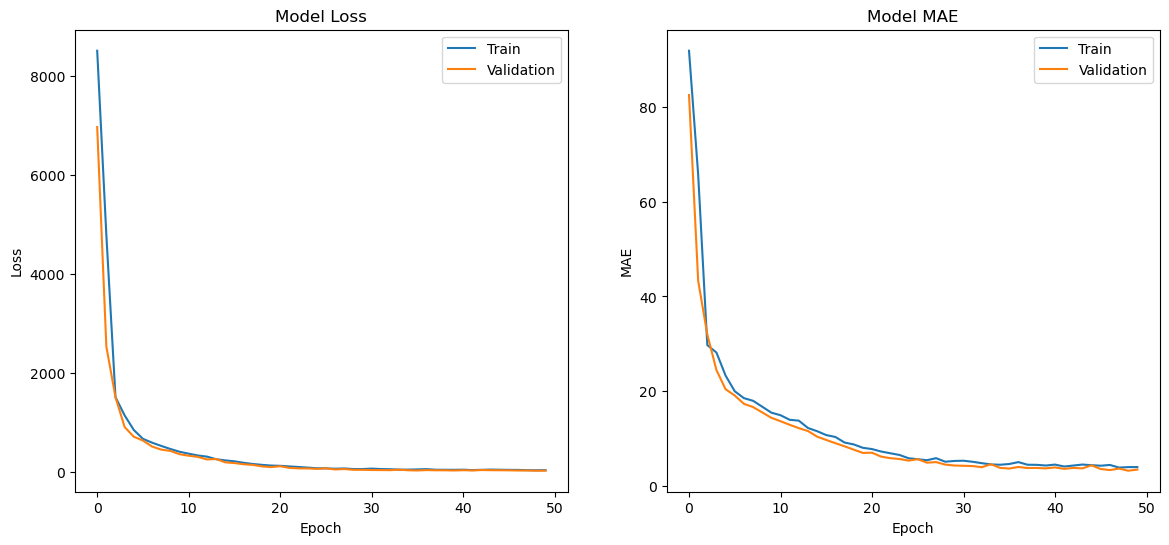

In [6]:
# Plot training & validation loss values
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation MAE values
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()
